In [1]:
from typing import Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

## 季節自己回帰和分移動平均(SARIMA)モデルを調べる

### データとその適切な頻度

| データ収集| 頻度$m$|
| ---- | ---- |
|年次 | 1 |
| 四半期次 | 4 |
| 月次 | 12 |
| 週次 | 52 |

### 日次またはそれよりも短いデータの周期に応じた頻度

| データ収集 | 分 | 時 | 日 | 週 | 年 |
| ---- | ---- | ---- | ---- | ---- | ---- |
| 毎日 | | | | 7 | 365 |
| 毎時 | | | 24 | 168 | 8766 |
| 毎分 | | 60 | 1440 | 10080 | 525960 |
| 毎秒 | 60 | 3600 | 86400 | 604800 | 31557600 |

## 時系列で季節パターンを特定する

In [2]:
url = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/air-passengers.csv'
df = pd.read_csv(url, index_col='Month')
df.index = pd.to_datetime(df.index, format=('%Y-%m')).to_period('M')

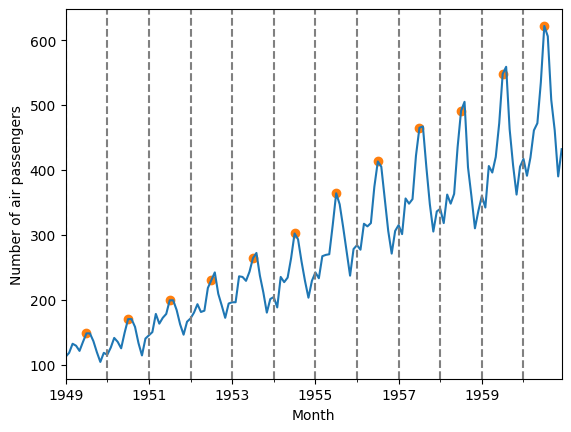

In [3]:
fig, ax = plt.subplots()
ax.set_ylabel('Number of air passengers')
df['Passengers'].plot(ax=ax)
ser_month7 = df[df.index.month == 7]['Passengers']
plt.scatter(ser_month7.index, ser_month7, color='tab:orange')
for year_start in df.index[df.index.month==1]:
    ax.axvline(year_start, color='gray', ls='dashed')
plt.show()

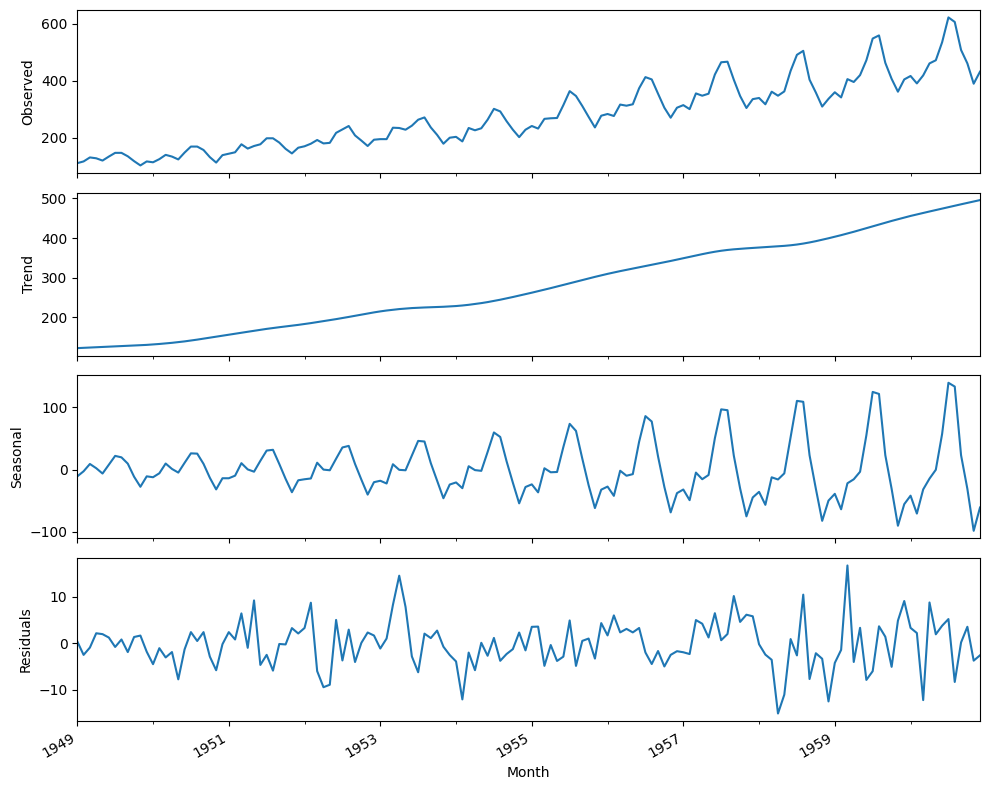

In [4]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axes[0].set_ylabel('Observed')
decomposition.observed.plot(ax=axes[0])

axes[1].set_ylabel('Trend')
decomposition.trend.plot(ax=axes[1])

axes[2].set_ylabel('Seasonal')
decomposition.seasonal.plot(ax=axes[2])

axes[3].set_ylabel('Residuals')
decomposition.resid.plot(ax=axes[3])

fig.autofmt_xdate()
plt.tight_layout()

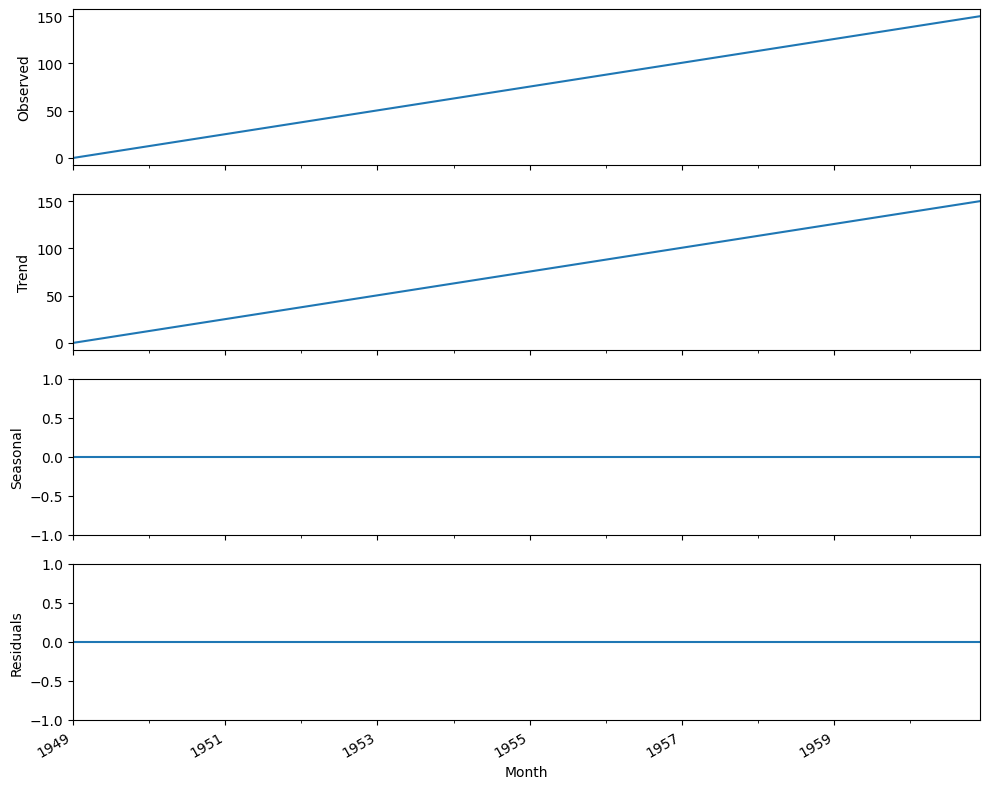

In [5]:
# 比較のために線形の値を入れたもののSTLを見てみる
# 残差成分が0になっているのが確認できる
df_linear = pd.DataFrame(
    data={'linear': np.linspace(0, 150, df.index.shape[0])},
    index=df.index
)
decomposition = STL(df_linear['linear'], period=12).fit()

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))

axes[0].set_ylabel('Observed')
decomposition.observed.plot(ax=axes[0])

axes[1].set_ylabel('Trend')
decomposition.trend.plot(ax=axes[1])

axes[2].set_ylabel('Seasonal')
axes[2].set_ylim(-1, 1)
decomposition.seasonal.plot(ax=axes[2])

axes[3].set_ylabel('Residuals')
axes[3].set_ylim(-1, 1)
decomposition.resid.plot(ax=axes[3])

fig.autofmt_xdate()
plt.tight_layout()

## 月ごとの航空旅客数を予測する

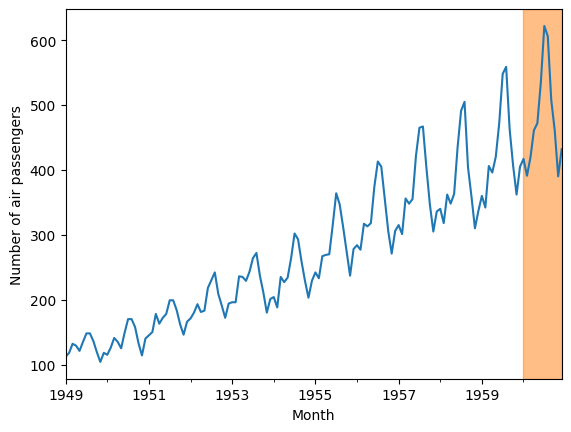

In [6]:
train = df.iloc[:-12]
test = df.iloc[-12:]

# plot
fig, ax = plt.subplots()
ax.set_ylabel('Number of air passengers')
df['Passengers'].plot(ax=ax)
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
plt.show()

### ARIMA(p,d,q)モデルで予測する

In [7]:
for d in [0, 1, 2]:
    ADF_result = adfuller(np.diff(df['Passengers'], n=d))
    print(f'月間航空旅客数({d}次差分)ADF検定')
    print(f'ADF Statistic: {ADF_result[0]:.3f}')
    print(f'p-value: {ADF_result[1]:.3f}')

月間航空旅客数(0次差分)ADF検定
ADF Statistic: 0.815
p-value: 0.992
月間航空旅客数(1次差分)ADF検定
ADF Statistic: -2.829
p-value: 0.054
月間航空旅客数(2次差分)ADF検定
ADF Statistic: -16.384
p-value: 0.000


In [8]:
# 一意なSARIMA(p,q)モデルをすべて適合させる関数
def optimize_SARIMA(endog: Union[pd.Series, list], orders: list, d: int, D: int, s: int) -> pd.DataFrame:
    """
    endog: 時系列データ
    orders: ARIMA(p, d, q)のpとqの値の組み合わせ
    d: 和分次数
    D: 季節差分の次数
    s: 頻度
    """
    res = []
    for order in tqdm(orders):
        try:
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s), 
                simple_differencing=False
            ).fit(disp=False)
            res.append([order, model.aic])
        except:
            continue
    df_res = (
        pd.DataFrame(res, columns=['(p,q,P,Q)', 'AIC'])
        .sort_values(by='AIC', ascending=True)
        .reset_index(drop=True)
    )
    return df_res

In [13]:
d = 2 # 差分を2回取る
D = 0 # ARIMA(p, d, q)モデルを使う
s = 12 # statsmodelsにおいてs=頻度(m)である、今回は月次なので12

# p, qをそれぞれ0~12まで動かす
# P, Qはゼロに固定
orders = list(product(range(13), range(13), [0], [0]))
optimize_SARIMA(train['Passengers'], orders, d, D, s) # なぜか(10, 12, 0, 0)のAICが小さすぎる

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q, P, Q)",AIC
0,"(10, 12, 0, 0)",64.550735
1,"(11, 3, 0, 0)",1016.842652
2,"(11, 4, 0, 0)",1019.034751
3,"(11, 5, 0, 0)",1020.379289
4,"(11, 1, 0, 0)",1021.025922
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


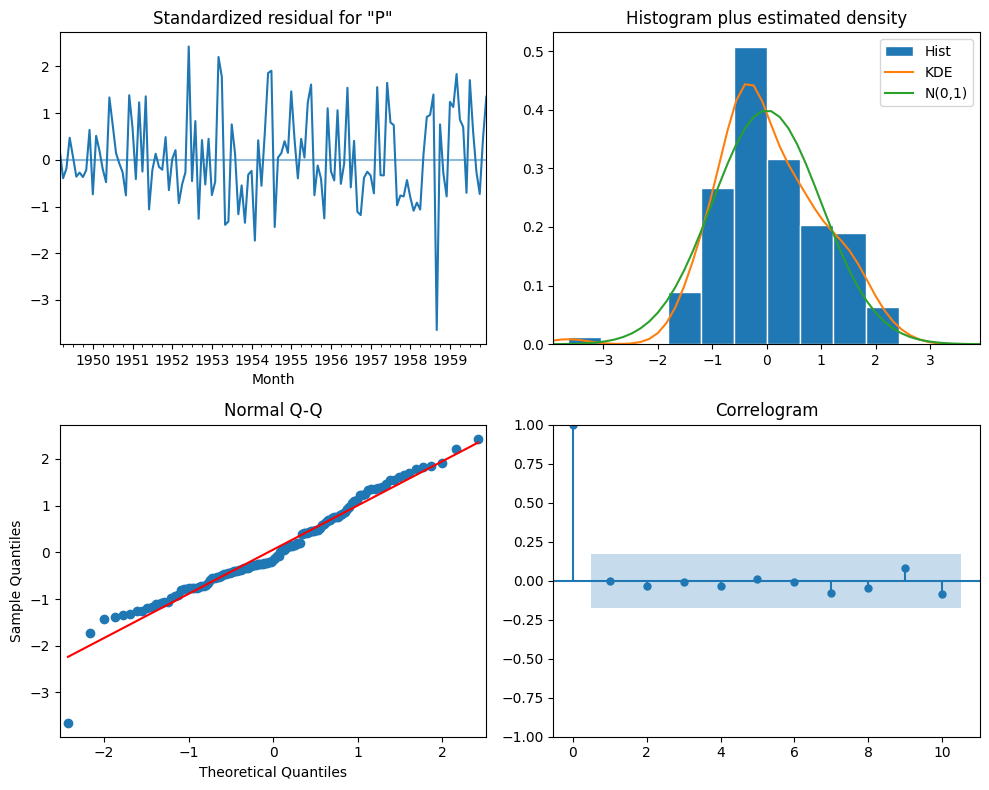

In [20]:
model_ARIMA = SARIMAX(train, order=(11, d, 3), simple_differencing=False).fit(disp=False)

model_ARIMA.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

In [22]:
# 残差自体は無相関ではない
# 1, 2番目が0.05よりも小さい
# ARIMAの限界を示している
acorr_ljungbox(model_ARIMA.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,6.539124,0.010553
2,6.667840,0.035653
3,6.943387,0.073724
4,7.736593,0.101718
5,8.377928,0.136601
6,8.669212,0.193054
7,9.493241,0.219155
8,9.731307,0.284393
9,9.741755,0.371793
10,11.546080,0.316583


### SARIMA(p,d,q)(P,D,Q)$_{m}$モデルで予測する

In [28]:
# 定常性の確認
ADF_result = adfuller(df['Passengers'])
print(f'月間航空旅客数(0次差分)ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')
ADF_result = adfuller(np.diff(df['Passengers']))
print(f'月間航空旅客数(1次差分)ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')
# 季節差分を使うとm=12
ADF_result = adfuller(np.diff(np.diff(df['Passengers']), n=12))
print(f'月間航空旅客数(1次差分、季節1次差分)ADF検定')
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

月間航空旅客数(0次差分)ADF検定
ADF Statistic: 0.815
p-value: 0.992
月間航空旅客数(1次差分)ADF検定
ADF Statistic: -2.829
p-value: 0.054
月間航空旅客数(1次差分、季節1次差分)ADF検定
ADF Statistic: -17.625
p-value: 0.000


In [29]:
d = 1 # 差分を2回取る
D = 1 # ARIMA(p, d, q)モデルを使う
s = 12 # statsmodelsにおいてs=頻度(m)である、今回は月次なので12

# p,q,P,Qを0~3まで動かす
orders = list(product(range(4), repeat=4))
optimize_SARIMA(train['Passengers'], orders, d, D, s)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q, P, Q)",AIC
0,"(2, 1, 1, 2)",892.245047
1,"(2, 1, 1, 3)",894.082348
2,"(1, 0, 1, 2)",894.287272
3,"(2, 1, 2, 3)",894.476601
4,"(0, 1, 1, 2)",894.991248
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.543943
254,"(0, 0, 3, 0)",908.742583


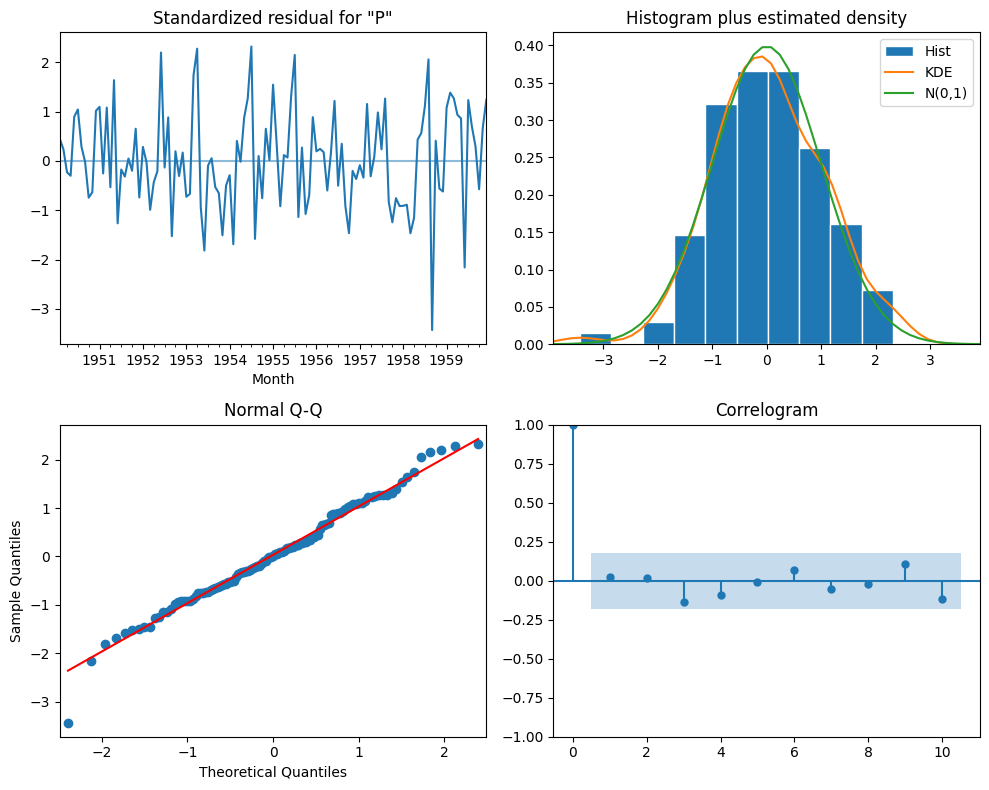

In [30]:
# 最もAICが小さいのは(2, 1, 1, 2)
model_SARIMA = SARIMAX(train, order=(2, d, 1), seasonal_order=(1, D, 2, s), simple_differencing=False).fit(disp=False)

model_SARIMA.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()

In [33]:
# 残差がランダムであることも確認できる
# SARIMAによる有効性が確認できる
acorr_ljungbox(model_SARIMA.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,0.004324,0.947568
2,0.746951,0.688338
3,1.022840,0.795726
4,1.227835,0.873495
5,1.437620,0.920154
6,1.713606,0.944066
7,2.309311,0.940759
8,2.721393,0.950608
9,2.737798,0.973790
10,4.976175,0.892764


In [36]:
# 最後に予測を行って結果の比較をする
test['naive_seasonal'] = train['Passengers'].iloc[-12:].values
test['ARIMA'] = model_ARIMA.forecast(12)
test['SARIMA'] = model_SARIMA.forecast(12)

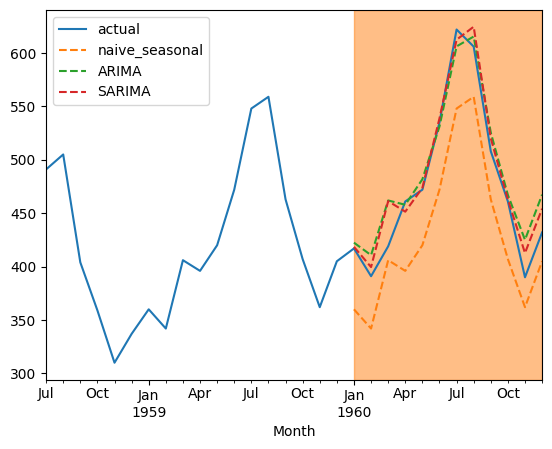

In [38]:
fig, ax = plt.subplots()
df['Passengers'].iloc[-30:].plot(ax=ax, label='actual')
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
methods = ['naive_seasonal', 'ARIMA', 'SARIMA']
for method in methods:
    test[method].plot(ax=ax, label=method, ls='dashed')
ax.legend()

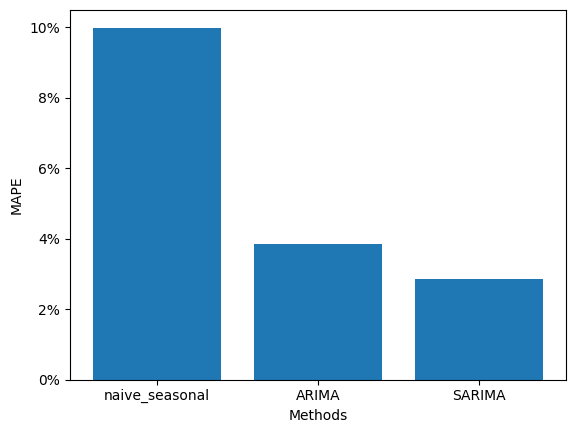

In [39]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

plt.xlabel('Methods')
plt.ylabel('MAPE')
plt.bar(
    methods,
    [mape(test['Passengers'], test[method]) for method in methods]
)
plt.gca().yaxis.set_major_formatter(lambda y, _: '{:.0%}'.format(y))
plt.show()